# Garg problem: interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Garg test case of the paper: "A unified framework for the numerical solution of optimal control problems using pseudospectral methods", Garg et al, 2010

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above or press shift+enter. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

All of the code used in this example is open-source and free to use.

[SymPy](https://www.sympy.org/en/index.html) is used for Symbolic formulation and manipulation of the problem.

[Numpy](https://numpy.org/) is used for numerical arrays and operations.

[CasADI](https://web.casadi.org/) is used for optimization.

[Chords](https://github.com/AunSiro/optibot) is the name of the package where we are compiling our code. We aim to produce a toolbox for Optimal Control Problems, focused on robotics, including a high level, readable and clean interface between the prior three packages.

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify, Matrix, exp, log, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [4]:
from functools import lru_cache
from copy import copy

In [5]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

In [6]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

## Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [7]:
# Creating symbols and dynamic symbols

u, t = symbols('u t')
x = dynamicsymbols('x')

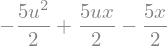

In [8]:
# Definition of the physics system

x_dot = 5*(-x +x*u -u**2)/2
x_dot

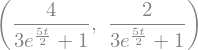

In [9]:
# Exact solution

a = 1 + 3 * exp(5*t/2)
b = exp(-5) + 6 + 9*exp(5)
x_true = 4/a
u_true = x_true/2
lambda_true = -exp(2 * log(a)-5*t/2)/b
x_true, u_true

In [10]:
x_true_num = lambdify(t, x_true)
x_d_true_num = lambdify(t, x_true.diff())
u_true_num = lambdify(t, u_true)

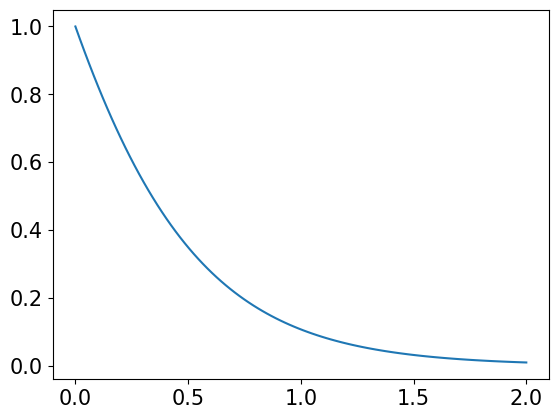

In [11]:
t_arr = np.linspace(0,2,100)
plt.plot(t_arr, x_true_num(t_arr))

### Casadi optimization

We have generated the system equations symbolicaly. Now, we translate them to CasADi objects in order to perform the optimization.

In [12]:
from chords.opti import Opti_Problem
import time
from functools import lru_cache

# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

def gen_ini_guess(N = 25, ini_guess = 'lin'):
    '''
    Generates an initial guess for the Cartpole problem of N intervals.
    '''
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess


import time
def chrono_solve(opti, solve_repetitions):
    '''
    Calls the solver a certain amount of times and returns the last solution
    obtained and the average computing time
    '''
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


In [13]:
from chords.casadi import implicit_dynamic_x_to_casadi_function, rhs_to_casadi_function

In [14]:
rhs_to_casadi_function([x_dot,], [x,], [u,], verbose = True)

x vars expected: [x, x_dot]
x vars found: [x]
u vars found: [u]
Lambda variables are not separated from parameters
a variables are not separated from parameters
Parameters found: []
Function Arguments:
	x: [x, x_dot]
	u: [u]
	params: []



Function(F:(x[2],u,params[0])->(x_dot[1x2]) MXFunction)

In [15]:
imp_F_x_cas = implicit_dynamic_x_to_casadi_function([x_dot - x.diff(),], [x,], [u,], verbose = True)
params = []
imp_F_x_cas

x vars expected: [x, x_dot]
x vars found: [x, x_dot]
u vars found: [u]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: []
Function Arguments:
	x: [x]
	x_dot: [x_dot]
	u: [u]
	lambdas: []
	params: []



Function(M:(x,x_dot,u,lambdas[0],params[0])->(residue) MXFunction)

In [224]:
_op = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = 'trapz',
        ini_guess= 'zero',
        t_end = 2,
        verbose=True,
        silent=False,
    )

Dynamics detected: Function


In [225]:
_op.dynamic_setup('f_x_impl', 1, 1, order = 1)

In [226]:
s_opts = {
    "max_iter": 10000,
    "tol": 1e-15,
}
_op.opti_setup(5, s_opts=s_opts)

_op.initial_guess([1,], [0,])

In [227]:
_op.apply_scheme()
opti = _op.opti
X = _op.opti_arrs['x']
X_d = _op.opti_arrs['x_d']
U = _op.opti_arrs['u']
X_s = _op.opti_points['x_s']
X_e = _op.opti_points['x_e']
#_op.u_sq_cost()
cost = -X_e
_op.cost = cost
_op.opti.minimize(cost)

In [228]:
# Appliying restrictions and action boundaries
u_m = 100.0
u_min = -100.0
N = U.shape[0]
for ii in range(N):
    _op.opti.subject_to(opti.bounded(u_min,U[ii,:],u_m))
_op.opti.subject_to(opti.bounded(u_min,U[-1, :],u_m))

In [229]:
# Initial and final conditions
opti.subject_to(X_s.T == [1,])



# Appliying restrictions and action boundaries
u_m = 20
N = _op.n_coll
for ii in range(N):
    opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))

In [230]:
if _op.scheme_mode == 'equispaced':
    _op.opti.set_initial(U, u_true_num(_op.opti_arrs['t']))
else:
    _op.opti.set_initial(U, u_true_num(_op.opti_arrs['t_col']))

_op.opti.set_initial(X, x_d_true_num(_op.opti_arrs['t']))
_op.opti.set_initial(X_d, x_true_num(_op.opti_arrs['t']))

#if 'parab' in _op.scheme:
    

In [231]:
_op.chrono_solve(solve_repetitions=1,)

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       39
Number of nonzeros in inequality constraint Jacobian.:        7
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:        7
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        7
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2359273e-02 2.88e+00 1.90e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [232]:
import importlib
import chords
importlib.reload(chords)
importlib.reload(chords.util)
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.opti)
from chords.opti import Opti_Problem

In [233]:
_res = _op.results

In [234]:
_res.keys()

dict_keys(['cpudt', 'iter_count', 'cost', 'opti_stats', 'x', 'x_d', 'x_like_u', 'x_d_like_u', 'u', 'u_like_x', 't', 'lam', 'q', 'q_like_u', 'v', 'v_like_u'])

In [235]:
_res['x'][0]

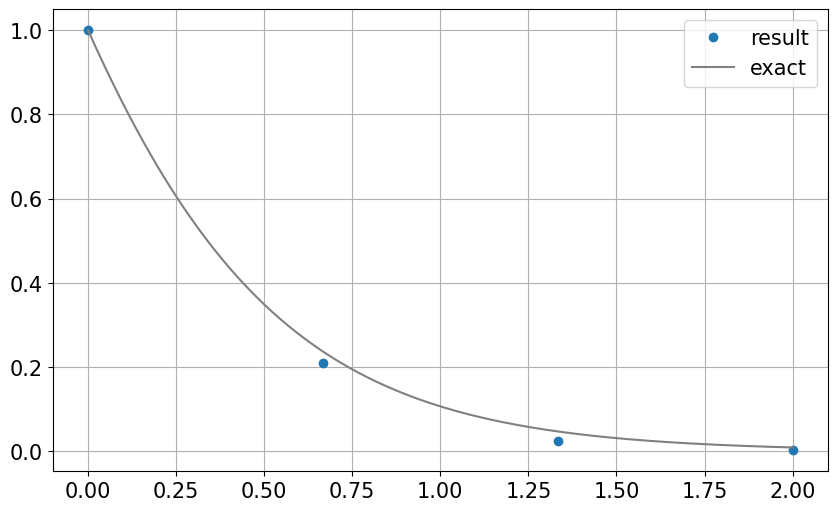

In [289]:
plt.figure(figsize=oct_fig_size)
plt.plot(_res['t'],_res['x'], 'o', label = 'result')
t_arr = np.linspace(0,2,500)
plt.plot(t_arr, x_true_num(t_arr), 'grey', label = 'exact')
plt.legend()
#plt.yscale('log')
plt.grid()

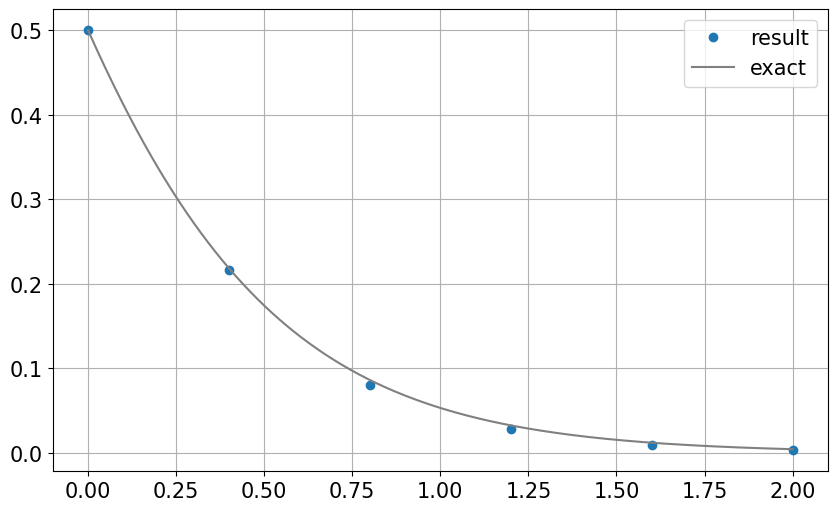

In [238]:
plt.figure(figsize=oct_fig_size)
plt.plot(_res['t'],_res['u'], 'o', label = 'result')
t_arr = np.linspace(0,2,500)
plt.plot(t_arr, u_true_num(t_arr), 'grey', label = 'exact')
plt.legend()
#plt.yscale('log')
plt.grid()

In [410]:
uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
    _res['x_d'],
    _res['x'],
    _res['u'],
    'LG',
    1,
    0,
    2,
    _res['u'].shape[0]
)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [411]:
plt.figure(figsize=[14,8])
t_interp_arr = np.linspace(0, 2, 500)
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], 'o', label = labels[ii])
    plt.plot(t_interp_arr, q_n_der_pols[0](t_interp_arr)[:,ii], 'grey')
plt.grid()
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1400x800 with 0 Axes>

In [412]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
for ii in range(2):
    plt.plot(_res['t'],_res['v'][:,ii], 'o', label = labels[ii])
    plt.plot(t_interp_arr, q_n_der_pols[1](t_interp_arr)[:,ii], 'grey')
plt.grid()
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1400x800 with 0 Axes>

plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(_res['t'],_res['a'][:,ii], 'o', label = labels[ii])
    plt.plot(t_interp_arr, q_n_der_pols[2](t_interp_arr)[:,ii], 'grey')
plt.grid()
plt.legend()

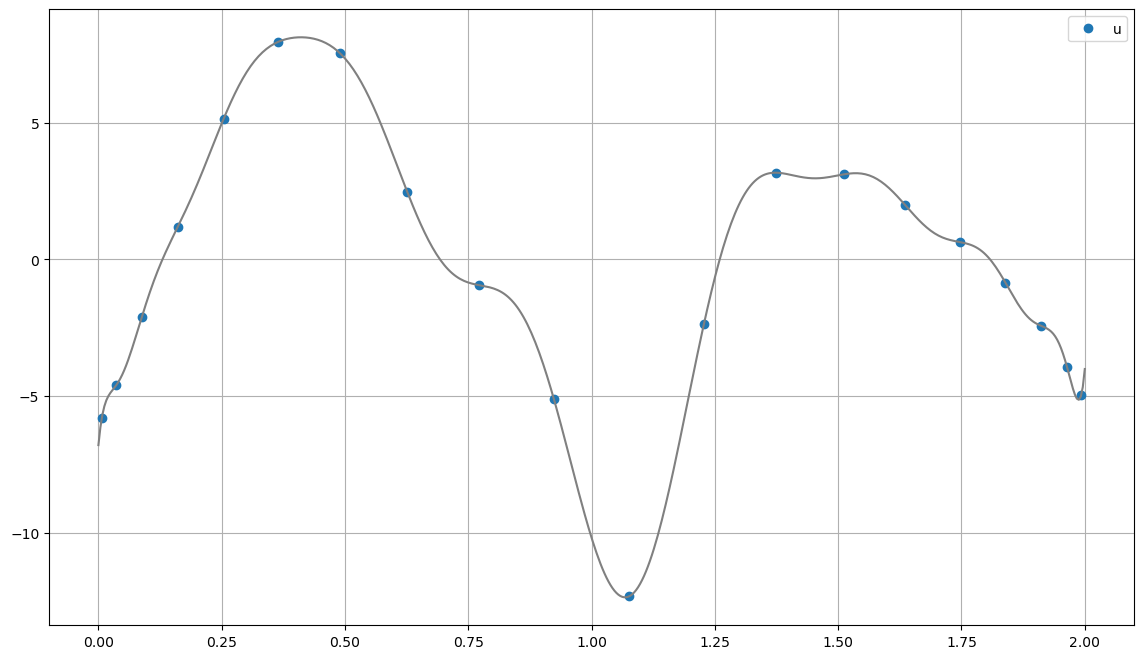

In [36]:
plt.figure(figsize=[14,8])
plt.plot(_res['t_col'],_res['u'][:], 'o', label = 'u')
plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey')
plt.grid()
plt.legend()

In [322]:
#@lru_cache(maxsize=None)
def casadi_garg(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 2, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=imp_F_x_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup('f_x_impl', 1, 1, order = 1)
    s_opts = {
        "max_iter": 10000,
        "tol": 1e-15,
        "constr_viol_tol":1e-15,
        "acceptable_tol":1e-15,
    }
    _opti.opti_setup(N, s_opts=s_opts)
    if ini_guess == 'lin':
        _opti.initial_guess([1,], [0,])
    _opti.apply_scheme()
    
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    X_d = _opti.opti_arrs['x_d']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    
    cost = -X_e
    _opti.cost = cost
    _opti.opti.minimize(cost)
        
   # Initial and final conditions
    opti.subject_to(X_s.T == [1,])
    
    if ini_guess != 'zero':
        if _opti.scheme_mode == 'equispaced':
            _opti.opti.set_initial(U, u_true_num(_opti.opti_arrs['t']))
        else:
            _opti.opti.set_initial(U, u_true_num(_opti.opti_arrs['t_col']))

        _opti.opti.set_initial(X, x_d_true_num(_opti.opti_arrs['t']))
        _opti.opti.set_initial(X_d, x_true_num(_opti.opti_arrs['t']))
    
    u_m = 1.0
    u_min = -1
    
    x_m = 2.0
    x_min = -2.0
    
    for ii in range(U.shape[0]):
        _opti.opti.subject_to(opti.bounded(u_min,U[ii,:],u_m))
    
    for ii in range(X.shape[0]):
        #_opti.opti.subject_to(opti.bounded(x_min,X[ii,:],x_m))
        pass
    
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

Let's try to solve the problem for 25 points and the 2nd order Hermite Simpson

In [323]:
from chords.piecewise import interpolated_array, interpolated_array_derivative
from chords.analysis import dynamic_error
from chords.numpy import RHS2numpy

In [324]:
casadi_garg(scheme,n_col, 'lin',solve_repetitions=1,silent=True,verbose=False)

{'cpudt': 0.015295028686523438,
 'iter_count': 9,
 'cost': -0.008963796802991543,
 'opti_stats': {'iter_count': 9,
  'iterations': {'alpha_du': [0.0,
    1.0,
    1.0,
    0.994663502800001,
    0.9352298308370195,
    1.0,
    1.0,
    1.0,
    0.9998577948993492,
    1.0],
   'alpha_pr': [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   'd_norm': [0.0,
    2.875,
    0.39061484013301373,
    0.021003147129412893,
    0.10416872865985435,
    0.04392646012238099,
    0.006481125844914392,
    7.223141304285702e-05,
    0.002237737812065766,
    1.8380028532086013e-05],
   'inf_du': [0.0056728629945872544,
    0.007831282030792417,
    2.602916044522509e-05,
    4.519781053841532e-06,
    3.709350852988776e-05,
    4.6346553766946744e-07,
    1.2016208767265717e-09,
    2.6574587223425396e-14,
    8.204813722161891e-10,
    1.0145298350819988e-14],
   'inf_pr': [2.875,
    0.361319738462625,
    0.019104065338229503,
    0.00043957420035178885,
    0.02654660692202082,
    0.00482

In [331]:
scheme = 'BU_LG'
n_col = 20
_res = casadi_garg(scheme, n_col, 'lin', solve_repetitions=1,  silent=False, verbose=True)

Dynamics detected: Function
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      565
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       64
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2359273e-02 2.88e+00 5.67e-03  -1.0 0.00e

casadi_garg(scheme, 20, 'lin', solve_repetitions=1,  silent=False, verbose=True)

In [327]:
_res['opti_stats']

{'iter_count': 9,
 'iterations': {'alpha_du': [0.0,
   1.0,
   1.0,
   0.994663502800001,
   0.9352298308370195,
   1.0,
   1.0,
   1.0,
   0.9998577948993492,
   1.0],
  'alpha_pr': [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'd_norm': [0.0,
   2.875,
   0.39061484013301373,
   0.021003147129412893,
   0.10416872865985435,
   0.04392646012238099,
   0.006481125844914392,
   7.223141304285702e-05,
   0.002237737812065766,
   1.8380028532086013e-05],
  'inf_du': [0.0056728629945872544,
   0.007831282030792417,
   2.602916044522509e-05,
   4.519781053841532e-06,
   3.709350852988776e-05,
   4.6346553766946744e-07,
   1.2016208767265717e-09,
   2.6574587223425396e-14,
   8.204813722161891e-10,
   1.0145298350819988e-14],
  'inf_pr': [2.875,
   0.361319738462625,
   0.019104065338229503,
   0.00043957420035178885,
   0.02654660692202082,
   0.004826757690910011,
   4.8095227092925796e-05,
   3.937750570059961e-09,
   1.2517496061681399e-05,
   6.412641528896756e-10],
  'mu': [0.1

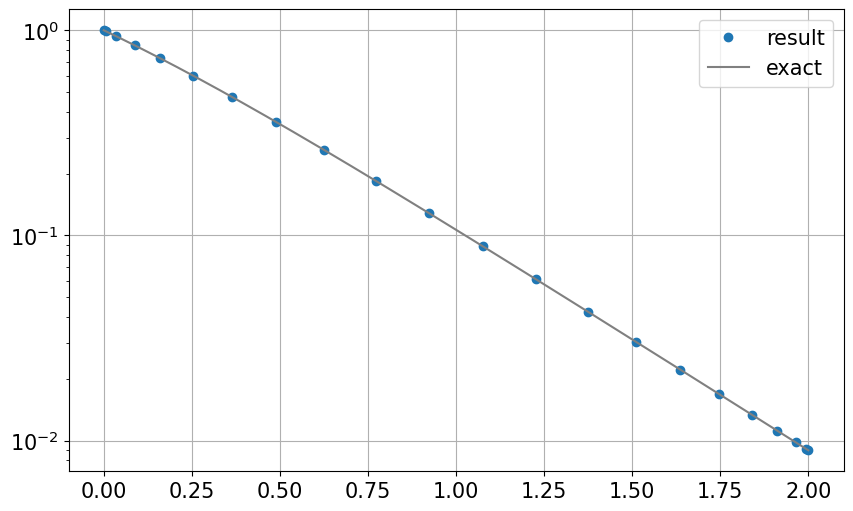

In [328]:
plt.figure(figsize=oct_fig_size)
plt.plot(_res['t'],_res['x'], 'o', label = 'result')
t_arr = np.linspace(0,2,500)
plt.plot(t_arr, x_true_num(t_arr), 'grey', label = 'exact')
plt.legend()
plt.yscale('log')
plt.grid()

In [282]:
np.max(_res['x']- x_true_num(_res['t']))

In [332]:
schemes = ['BU_LG', 'BU_LGR', 'BU_LGL', 'hs', 'trapz'] #If you defined a custom function, name your scheme here
#initials = ['']
solve_repetitions = 2 #Increase this number to get more reliable values of execution times
N_arr = np.arange(4, 42, 2)#[4, 5, 7, 10, 12, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40]
results = {}

for scheme in schemes:
        key = scheme 
        results[key] = {'N_arr':N_arr}
        results[key]['scheme'] = scheme
        results[key]['order'] = 1
            
for N in N_arr:
    print(f'\tN = {N}')
    for scheme in schemes:
        key = scheme
        print(f'Problem: {key}, ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        try:
            results[key][N] = casadi_garg(
            scheme,
            N, 
            'lin',
            solve_repetitions=solve_repetitions,
            silent=True, 
            verbose=False)
        except: 
            results[key][N] = None
            print('ATTEMPT FAILED!!')
            results[key][N] = copy(casadi_garg(
                scheme,
                20, 
                'lin',
                solve_repetitions=solve_repetitions,
                silent=True, 
                verbose=False))
            for item in results[key][N]:
                try:
                    results[key][N][item] = results[key][N][item]*np.nan
                except TypeError:
                    results[key][N][item] = np.nan

	N = 4
Problem: BU_LG,  16:53:32 
Problem: BU_LGR,  16:53:32 
Problem: BU_LGL,  16:53:32 
Problem: hs,  16:53:32 
Problem: trapz,  16:53:32 
	N = 6
Problem: BU_LG,  16:53:32 
Problem: BU_LGR,  16:53:32 
Problem: BU_LGL,  16:53:32 
Problem: hs,  16:53:32 
Problem: trapz,  16:53:32 
	N = 8
Problem: BU_LG,  16:53:32 
Problem: BU_LGR,  16:53:32 
Problem: BU_LGL,  16:53:32 
Problem: hs,  16:53:32 
Problem: trapz,  16:53:32 
	N = 10
Problem: BU_LG,  16:53:32 
Problem: BU_LGR,  16:53:32 
Problem: BU_LGL,  16:53:32 
Problem: hs,  16:53:32 
Problem: trapz,  16:53:32 
	N = 12
Problem: BU_LG,  16:53:32 
Problem: BU_LGR,  16:53:32 
Problem: BU_LGL,  16:53:32 
Problem: hs,  16:53:32 
Problem: trapz,  16:53:33 
	N = 14
Problem: BU_LG,  16:53:33 
Problem: BU_LGR,  16:53:33 
Problem: BU_LGL,  16:53:33 
Problem: hs,  16:53:33 
Problem: trapz,  16:53:33 
	N = 16
Problem: BU_LG,  16:53:33 
Problem: BU_LGR,  16:53:33 
Problem: BU_LGL,  16:53:33 
Problem: hs,  16:53:33 
Problem: trapz,  16:53:33 
	N = 18
P

In [333]:
for key in results.keys():
        for N in results[key]['N_arr']:
            case = results[key][N]
            case['err'] =  np.max(np.abs(case['x']- x_true_num(case['t'])))

In [334]:
for key in results.keys():
        _c = []
        _cpudt = []
        _iters = []
        _err = []
        for N in results[key]['N_arr']:
            _c.append(results[key][N]['cost'])
            _cpudt.append(results[key][N]['cpudt'])
            _iters.append(results[key][N]['iter_count'])
            _err.append(max(results[key][N]['err'], 1e-16))
        results[key]['cost'] = np.array(_c)
        results[key]['cpudt'] = np.array(_cpudt)
        results[key]['iter_count'] = np.array(_iters)
        results[key]['err'] = np.array(_err)

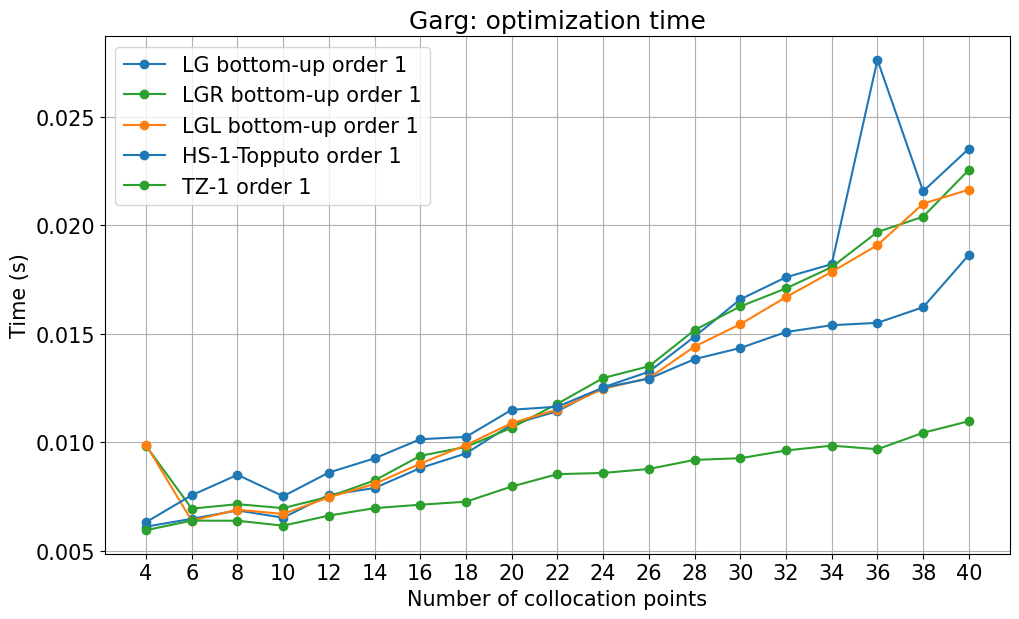

In [335]:
plt.figure(figsize=[10,6])
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Garg: optimization time')
plt.xlabel('Number of collocation points')
plt.ylabel('Time (s)')
#plt.yscale('log')
#plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
plt.xticks(ticks, labels=ticks)
_ = []

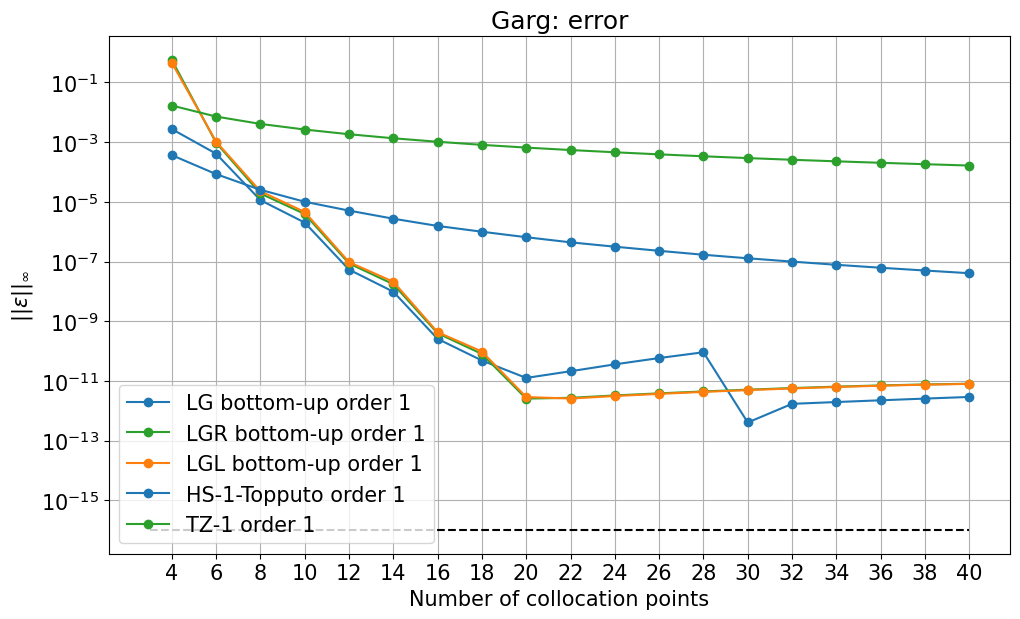

In [287]:
plt.figure(figsize=[10,6])
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'],
             results[key][f'err'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Garg: error')
plt.xlabel('Number of collocation points')
plt.ylabel('$||\epsilon||_\infty$')
plt.yscale('log')
#plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
plt.xticks(ticks, labels=ticks)
plt.hlines(1e-16, 3, 40, 'k', ls='--')
_ = []

In [288]:
results['BU_LGL']['err']

array([4.59047190e-01, 1.03859786e-03, 2.25294617e-05, 4.57248649e-06,
       9.57367468e-08, 2.09576808e-08, 4.30021463e-10, 9.64453517e-11,
       2.88125079e-12, 2.57061039e-12, 3.12494475e-12, 3.68538533e-12,
       4.28856950e-12, 4.92861307e-12, 5.59552404e-12, 6.26942942e-12,
       6.91957602e-12, 7.49078577e-12, 7.96029909e-12])

In [423]:
uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
    np.expand_dims(_res['x_d'],1),
    _res['x'][0],
    _res['u'],
    scheme,
    2,
    0,
    2,
    n_col
)

TypeError: object of type 'numpy.float64' has no len()

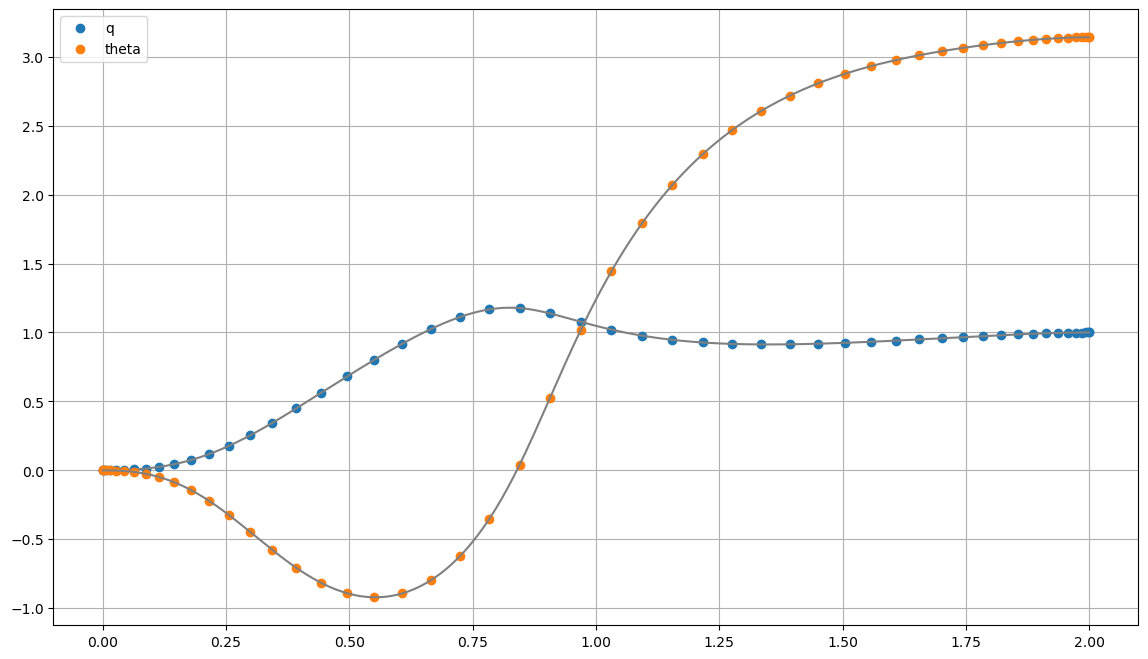

In [43]:
plt.figure(figsize=[14,8])
labels= ['q', 'theta']
for ii in range(2):
    plt.plot(_res['t'],_res['q'][:,ii], 'o', label = labels[ii])
    plt.plot(t_interp_arr, q_n_der_pols[0](t_interp_arr)[:,ii], 'grey')
plt.grid()
plt.legend()

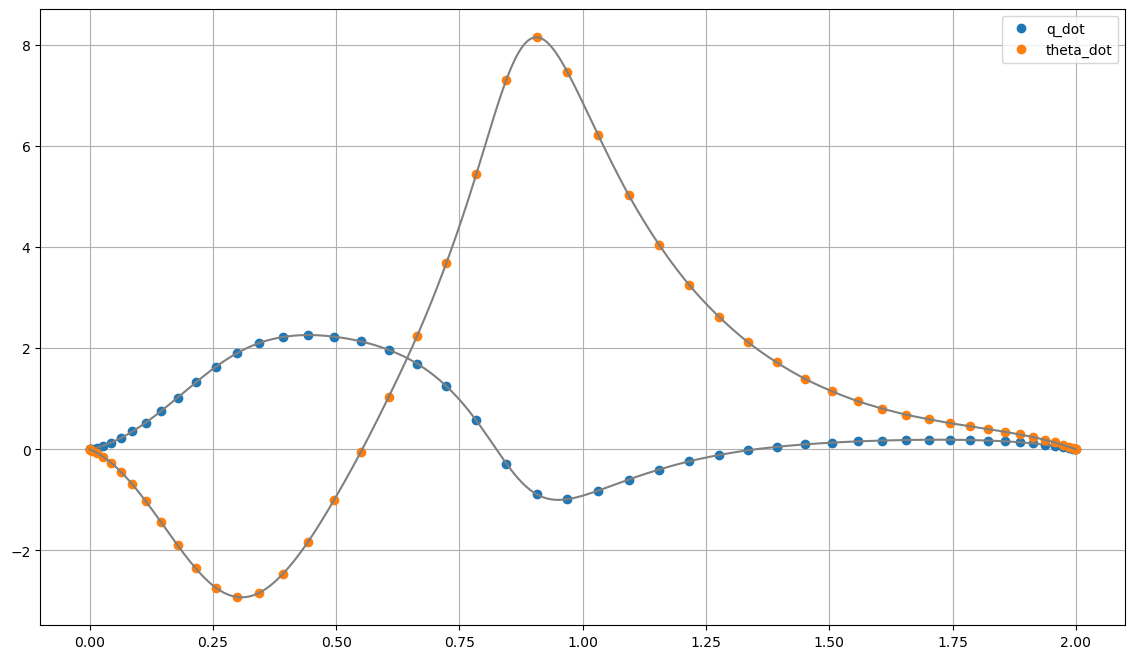

In [44]:
plt.figure(figsize=[14,8])
labels= ['q_dot', 'theta_dot']
for ii in range(2):
    plt.plot(_res['t'],_res['v'][:,ii], 'o', label = labels[ii])
    plt.plot(t_interp_arr, q_n_der_pols[1](t_interp_arr)[:,ii], 'grey')
plt.grid()
plt.legend()

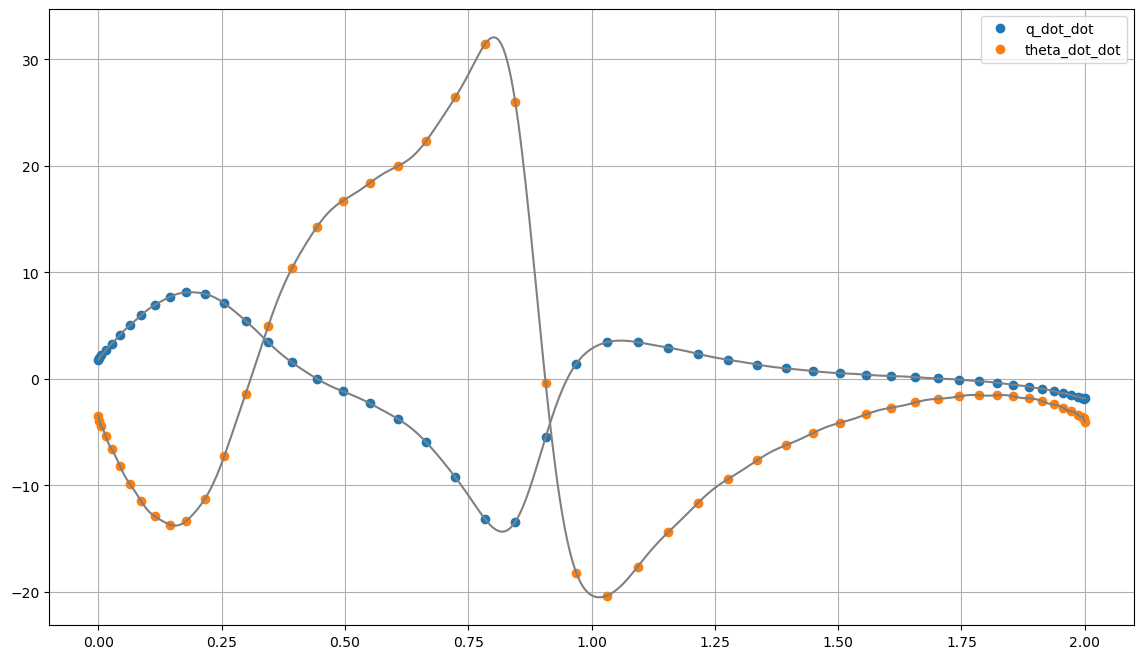

In [45]:
plt.figure(figsize=[14,8])
labels= ['q_dot_dot', 'theta_dot_dot']
for ii in range(2):
    plt.plot(_res['t'],_res['a'][:,ii], 'o', label = labels[ii])
    plt.plot(t_interp_arr, q_n_der_pols[2](t_interp_arr)[:,ii], 'grey')
plt.grid()
plt.legend()

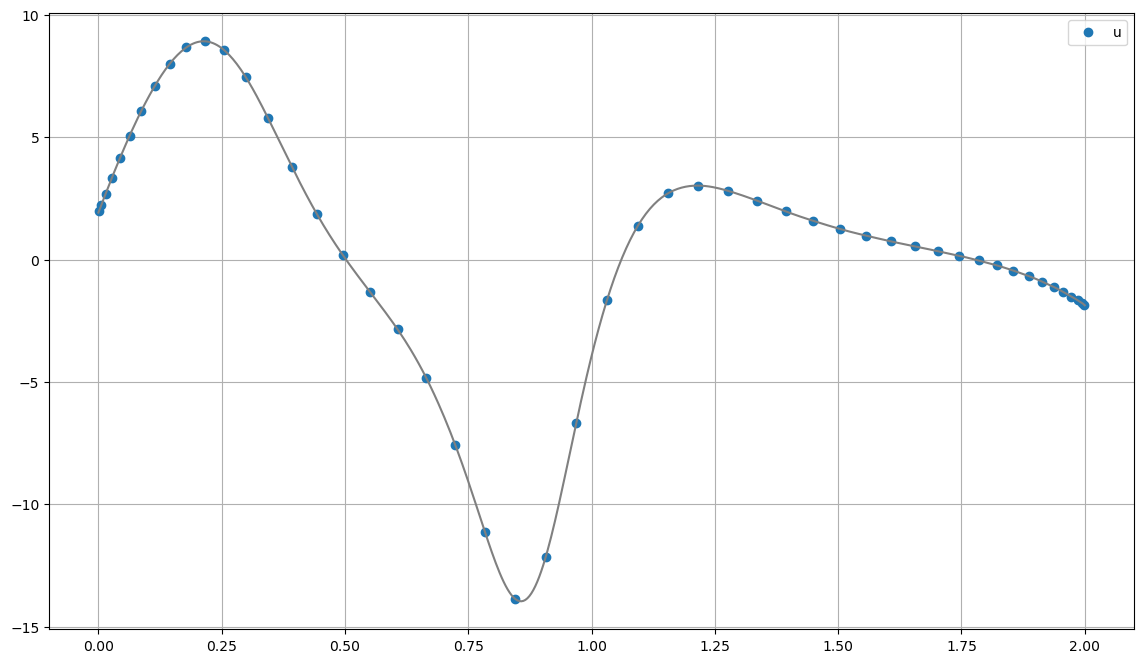

In [46]:
plt.figure(figsize=[14,8])
plt.plot(_res['t_col'],_res['u'][:], 'o', label = 'u')
plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey')
plt.grid()
plt.legend()

scheme = 'hs_mod_parab'
N = 25
xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, 'lin', 1)

xx_interp, uu_interp = interpolated_array(
    X = xx,
    U = uu,
    F = F_nump,
    h = 2/N,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : uu_c}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N+1),uu[:], 'o',label = '$u_k$ points')
plt.plot(np.linspace(0,2,2*N+1)[1::2],uu_c, 'o',label = '$u_c$ points')
plt.plot(np.linspace(0,2,2000),uu_interp, label = 'interpolation')
plt.grid()
plt.legend()
plt.title('Cart-pole U(t) for 2nd order Hermite Simpson with N = 25')
labels = ['q1','q2','v1','v2']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,2,N+1),xx[:,ii], 'o',label = f'${labels[ii]}_k$ points')
    plt.plot(np.linspace(0,2,2000),xx_interp[:,ii], label = 'interpolation')
    plt.grid()
    plt.legend()
    plt.title(f'Cart-pole {labels[ii]}(t) for 2nd order Hermite Simpson with N = 25')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Toputto',
        'hs_mod': 'HS-2-Toputto',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2'
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Toputto)',
          '2nd order Hermite Simpson (Toputto)',]
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod']
    lname_dict = {}
    for ii in range(6):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate(['hs_parab', 'trapz_mod', 'trapz', 'hs_mod_parab','hs', 'hs_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False):
    kwargs = {'marker' :'o', 'c':sch_to_color(sch)}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

In [47]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, set_fonts)
set_fonts()

## Sistematic comparison of schemes for different values of N

Now let's solve the problem with different methods.

### Caution!

Executing the next cell may require some time!

casadi_cartpole(
                    'BU_LG',
                    15, 
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = 2,
                    silent=True, 
                    verbose=False)

for item in _b:
    _a[item] = _b[item]

In [ ]:
schemes = ['BU_LG', 'BU_LGR', 'BU_LGL'] #If you defined a custom function, name your scheme here
initials = ['lin']
solve_repetitions = 2 #Increase this number to get more reliable values of execution times
N_arr = [
    5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100,
    110, 120, 125, 130, 140, 150, 160, 170, 175, 190, 180, 200, 220, 225, 240, 250, 260, 275,
    280, 300, 325, 350, 375, 400,]# 425, 450, 475, 500, 525, 550, 575, 600]# You can increase the numbers here, but it will take more time
#N_arr = [50, 60,]
results = {}

for scheme in schemes:
        for order in range(1,3):
            key = scheme + f'_{order}'
            results[key] = {'N_arr':N_arr}
            results[key]['scheme'] = scheme
            results[key]['order'] = order
            
for N in N_arr:
    print(f'\tN = {N}')
    for scheme in schemes:
        for order in range(1,3):
            key = scheme + f'_{order}'
            print(f'Problem: {key}, ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
            try:
                results[key][N] = casadi_cartpole(
                scheme,
                N, 
                'lin',
                solve_repetitions=solve_repetitions,
                order = order,
                silent=True, 
                verbose=False)
            except: 
                results[key][N] = None
                print('ATTEMPT FAILED!!')
                results[key][N] = copy(casadi_cartpole(
                    scheme,
                    20, 
                    'lin',
                    solve_repetitions=solve_repetitions,
                    order = 2,
                    silent=True, 
                    verbose=False))
                for item in results[key][N]:
                    try:
                        results[key][N][item] = results[key][N][item]*np.nan
                    except TypeError:
                        results[key][N][item] = np.nan
        


	N = 5
Problem: BU_LG_1,  10:06:44 
ATTEMPT FAILED!!
Problem: BU_LG_2,  10:06:48 
Problem: BU_LGR_1,  10:06:48 
Problem: BU_LGR_2,  10:06:49 
Problem: BU_LGL_1,  10:06:50 
Problem: BU_LGL_2,  10:06:50 
ATTEMPT FAILED!!
	N = 7
Problem: BU_LG_1,  10:06:50 
Problem: BU_LG_2,  10:06:51 
Problem: BU_LGR_1,  10:06:52 
Problem: BU_LGR_2,  10:06:54 
Problem: BU_LGL_1,  10:06:55 
ATTEMPT FAILED!!
Problem: BU_LGL_2,  10:06:55 
	N = 10
Problem: BU_LG_1,  10:06:55 
Problem: BU_LG_2,  10:06:56 
Problem: BU_LGR_1,  10:06:58 
Problem: BU_LGR_2,  10:06:59 
Problem: BU_LGL_1,  10:07:01 
Problem: BU_LGL_2,  10:07:01 
ATTEMPT FAILED!!
	N = 12
Problem: BU_LG_1,  10:07:01 
Problem: BU_LG_2,  10:07:03 
Problem: BU_LGR_1,  10:07:05 
Problem: BU_LGR_2,  10:07:07 
Problem: BU_LGL_1,  10:07:08 
Problem: BU_LGL_2,  10:07:08 
	N = 15
Problem: BU_LG_1,  10:07:09 
Problem: BU_LG_2,  10:07:11 
Problem: BU_LGR_1,  10:07:13 
Problem: BU_LGR_2,  10:07:15 
Problem: BU_LGL_1,  10:07:17 
Problem: BU_LGL_2,  10:07:17 
	N =

In [ ]:
for key in results.keys():
        _c = []
        _cpudt = []
        _iters = []
        for N in results[key]['N_arr']:
            _c.append(results[key][N]['cost'])
            _cpudt.append(results[key][N]['cpudt'])
            _iters.append(results[key][N]['iter_count'])
        results[key]['cost'] = np.array(_c)
        results[key]['cpudt'] = np.array(_cpudt)
        results[key]['iter_count'] = np.array(_iters)

#titles = ['LG','LG2']#'D2', 'LGL', 
schemes =['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab',]
plt.figure(figsize=oct_fig_size)
for ii in range(len(schemes)):
    key = schemes[ii]
    plt.plot(
        results[key]['N_arr'],
        results[key][f'cpudt'],
        **scheme_kwargs(key, longlabel=False)
    )
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Cart-pole: Optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
#plt.savefig('2d_order/5_link_optimization_vs_interval_number.pdf', format='pdf')

In [ ]:
plt.figure(figsize=oct_fig_size)
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'], results[key]['cost'][:], **plot_kw)
#plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

N = 60
scheme = 'BU_LG'
plt.figure(figsize=[14,8])

for ii in range(1,3):
    key = scheme + f'_{ii}'
    uu_pol, q_n_der_pols = chords.bu_pseudospectral.Polynomial_interpolations_BU(
        results[key][N]['x_d'],
        results[key][N]['x'][0,:],
        results[key][N]['u'],
        scheme,
        ii,
        0,
        2,
        N
    )
    

    plt.plot(results[key][N]['t_col'],results[key][N]['u'][:], 'o', label = 'u ' + key)
    plt.plot(t_interp_arr, uu_pol(t_interp_arr), 'grey',':')
plt.grid()
plt.legend()
points_ii = np.array([0, 12, 27, 33, 59])
uu_in = results[key][N]['u'][points_ii]
tt_in = results[key][N]['t_col'][points_ii]
plt.plot(tt_in,uu_in, '-', label = 'u interp')

## Dynamic Error

Now we can compute the dynamic errors for each case

In [ ]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [ ]:
import chords
import importlib
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.util)
from chords.util import sch_to_color, sch_to_lab

In [ ]:
from chords.bu_pseudospectral import dynamic_error_BU, interpolations_deriv_BU_pseudospectral

In [ ]:
n_interp = 2000
for key in results.keys():
    scheme = results[key]['scheme'] 
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        dynamic_errors = dynamic_error_BU(
            x_arr = results[key][N]['x'],
            x_dot_arr = results[key][N]['x_d'],
            u_arr = results[key][N]['u'],
            params = params,
            scheme = scheme,
            tf = results[key][N]['t'][-1],
            F = F_nump,
            t0 = 0,
            scheme_order=2,
            u_interp = "pol",
            x_interp = "pol",
            n_interp=n_interp,
            scheme_params=None,
            mode="q",
        )
        dyn_err_q = dynamic_errors[0][0]
        dyn_err_v = dynamic_errors[0][1]
        dyn_err_2 = dynamic_errors[1][0]
        results[key][N]['dyn_err_q'] = dyn_err_q
        results[key][N]['dyn_err_v'] = dyn_err_v
        results[key][N]['dyn_err_2'] = dyn_err_2
        t_arr = np.linspace(0,2, n_interp)
        tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
        tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
        tot_dyn_err_2 = total_state_error(t_arr, dyn_err_2)
        results[key][N]['err_q_int'] = dyn_err_q
        results[key][N]['err_v_int'] = dyn_err_v
        results[key][N]['err_2_int'] = dyn_err_2
        results[key][N]['err_q'] = tot_dyn_err_q
        results[key][N]['err_v'] = tot_dyn_err_v
        results[key][N]['err_2'] = tot_dyn_err_2
            

In [ ]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [ ]:
for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    err_q_acum = []
    err_v_acum = []
    err_2_acum = []
    cpudt = []
    for N in N_arr:
        err_q_acum.append(results[key][N]['err_q'])
        err_v_acum.append(results[key][N]['err_v'])
        err_2_acum.append(results[key][N]['err_2'])
    results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
    results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
    results[key]['err_2_acum'] = np.array(err_2_acum, dtype = float)
    

In [ ]:
for key in results.keys():
    scheme = results[key]['scheme']
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_2'].shape[0])
            
        _derivs = interpolations_deriv_BU_pseudospectral(
            _case['x'],
            _case['x_d'],
            scheme,
            scheme_order = 2,
            deriv_order = 1,
            t0 = 0,
            tf = _case['t'][-1],
            x_interp="pol",
            n_interp=n_interp,
        )
        _accels = _derivs[:, 2:]
        
        #_case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2']) # NOT VALID
        _case[f'sum_dyn_err_2_arr'] = None
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        #_case['a_abs_sum_arr'] = arr_sum(_accels) # NOT VALID
        _case['a_abs_sum_arr'] = None
        
        _case['rel_dyn_err_2_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_2']/_case['a_arr'])
        _case['rel_dyn_err_2_arr_by_total_mean_sum'] = None
        _case['rel_dyn_err_2_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_2']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_2_arr_by_a_sum_arr_sum'] = None

def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

In [ ]:
from chords.util import plot_by_segments

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [ ]:
results[key][N].keys()

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_int'][cut_p:jj,ii], '-', c = sch_to_color(key), label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        # If you are running the notebook locally and want to save the plots,
        # uncomment the next line
        #plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [ ]:
#schemes = ['trapz', 'trapz_mod']
ylabels = ['Error $(m/s)$','Error $(rad/s)$']
N = 20

for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['dyn_err_q'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]["dyn_err_q"][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: compatibility error $\varepsilon^{[1]}_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    #plt.savefig(f'2d_order/Cartpole_First_Order_Dynamic_Error_q_{component+1}_TZ_schemes_N_{N}.eps', format='eps')

In [ ]:
ylabels = ['Error $(m/s^2)$','Error $(rad/s^2)$']
N = 20
for component in range(2):
    plt.figure(figsize=oct_fig_size)
    t_arr = np.linspace(
            0, results[key][N]["t"][-1], results[key][N]['dyn_err_q'].shape[0]
        )
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        plot_kw['marker'] = ''
        plt.plot(t_arr, results[key][N]["dyn_err_2"][:,component], **plot_kw)
    plt.plot(
        results[key][N]["t"],
        np.zeros(len(results[key][N]["t"])),
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    plt.legend()
    plt.grid()
    plt.title(r'Cartpole: dynamics error $\varepsilon_{q_'+f'{component+1}}}(t)$, N = {N}')
    plt.xlabel("Time(s)")
    plt.ylabel(ylabels[component])
    plt.tight_layout(pad=0.0)
    #plt.savefig(f'2d_order/Cartpole_Second_Order_Dynamic_Error_q_{component+1}_HS_schemes_N_{N}.eps', format='eps')

In [ ]:
data_array = ['err_q_acum','err_v_acum','err_2_acum','cpudt']
schemes = ['BU_LG', 'BU_LGR', 'BU_LGL']

data_key = data_array[2]
for qq in range(2):
    plt.figure(figsize=oct_fig_size)
    plt.title(r'Cart-pole: integral dynamics error $\int\varepsilon_{q_'+f'{qq+1}}}$')
    for key in results.keys():
        scheme = results[key]['scheme']
        plot_kw = scheme_kwargs(scheme, longlabel=False)
        plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
        plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,
             results[key][data_key],
             **plot_kw)
        else:
            plt.plot(N_arr,
             results[key][data_key][:,qq],
             **plot_kw)
    plt.yscale('log')
    ticks = np.array(results[key]['N_arr'])
    plt.xticks(ticks, labels=ticks)
    plt.xlabel('Number of colocation points')
    plt.grid()
    plt.legend()
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamics error $({units})$')
    plt.tight_layout(pad = 0.0)
    # If you are running the notebook locally and want to save the plots,
    # uncomment the next line
    #plt.savefig(f'BU_pseudo/Cartpole_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')

In [ ]:

plt.figure(figsize=[10,6])
for key in results.keys():
    scheme = results[key]['scheme']
    plot_kw = scheme_kwargs(scheme, longlabel=False)
    plot_kw['ls'] = '-' if results[key]['order'] == 1 else ':'
    plot_kw['label'] = plot_kw['label']+' order '+str(results[key]['order'])
    plt.plot(results[key]['N_arr'],
             results[key][f'cpudt'],
             **plot_kw)
plt.grid()
plt.legend()
plt.title('Cart-pole: optimization time')
plt.xlabel('Number of collocation points')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(pad = 0.0)
ticks = np.array(results[key]['N_arr'])
plt.xticks(ticks, labels=ticks)
# If you are running the notebook locally and want to save the plots,
# uncomment the next line
#plt.savefig(f'2d_order/Cartpole_optimization_time_vs_interval_number.eps', format='eps')

# Here we print the data shown in Table II of the paper
for scheme in ['trapz', 'trapz_mod', 'hs_parab', 'hs_mod_parab']:
    key = scheme 
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2'])

## Animation

from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(72)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    #circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    #ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
        
    xx_interpolated, uu_interpolated = interpolated_array(
        X,
        U,
        F = F_nump,
        h = 2/(N-1),
        t_array = np.linspace(0, 2, 5*(N-1)+1),
        params = params,
        scheme = 'hs_mod_parab',
        u_scheme = 'parab',
        scheme_params = {'u_c' : results['hs_mod_parab_lin'][N-1]['u_c']}
    )
    x_0_interp = xx_interpolated[:,0]
    y_0_interp = np.zeros_like(x_0_interp)
    x_1_interp = x_0_interp + l_n*np.sin(xx_interpolated[:,1])
    y_1_interp = y_0_interp - l_n*np.cos(xx_interpolated[:,1])
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        #circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        #circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1_interp[:5*i+1], y_1_interp[:5*i+1])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    frame_indices = np.concatenate((np.zeros(10, dtype=int), np.arange(0, N, 1), np.ones(15, dtype=int)*(N-1)))
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frame_indices, interval=20, 
                               blit=True)
    return anim

anim = create_anim(results['hs_parab_lin'][25]['x'], results['hs_parab_lin'][25]['u'], params)

HTML(anim.to_jshtml())

f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=12) 
# If you are running the notebook locally and want to save the animation,
# uncomment the next line
#anim.save(f, writer=writervideo)